## Single-family House Median Price Prediction by Neighborhood in Denver 
* Pick a neighbourhood and see the trend of house median price in Denver

In [4]:
# import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as geopd
import seaborn as sns
import sklearn

### Data Preparation
#### Step 1: Load data and group sale records to neighborhood level
* Data needed: cleaned_house_records.csv
* Original dataset (cleaned_house_records.csv) has single family house sales from 2000 to 2010 in Denver. Each sale record has the sale price, sale year, house features and neighborhood features
* Column['NBHD_ID'] stands for neighborhood ID.

In [5]:
df = pd.read_csv('../Data/cleaned_house_records.csv')

print('Columns: ', len(df.columns),'\n', list(df.columns))

Columns:  49 
 ['Unnamed: 0', 'AGE', 'AREA_ABG', 'AVG_HH_INC', 'BACHELORSO', 'BED_RMS', 'BSMT_AREA', 'CCAGE_RM', 'CCYRBLT', 'Colleges', 'Crimes', 'DrugDist', 'FBSMT_SQFT', 'FoodStores', 'GRD_AREA', 'HOUSING_UN', 'Intersects', 'K12s', 'LAND_SQFT', 'LESSTHANHS', 'Libraries', 'Malls', 'Marijuana', 'MaxPctRace', 'NBHD_ID', 'PCT_AGE65P', 'PCT_AGELES', 'PCT_SOLD', 'PCT_VAC', 'PER_CAPITA', 'POP_YEAR', 'ParkDist', 'Park_Coverage', 'Remodeled', 'SALE_MONTH', 'SALE_PRICE', 'SALE_PRICE_CPI_ADJ', 'SALE_YEAR', 'SCHEDNUM', 'STORY', 'StLights', 'StoreDist', 'TrAccident', 'Tree_Coverage', 'BATH_RMS', 'PER_COMM', 'MaxRaceTyp_BLACK', 'MaxRaceTyp_HISPAN', 'MaxRaceTyp_WHITE']


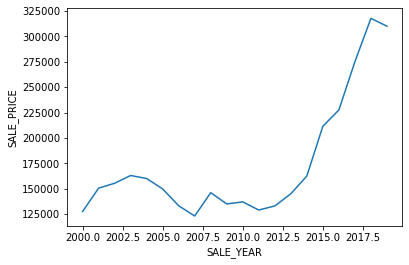

In [6]:
df_grouped = df.groupby(['NBHD_ID', 'SALE_YEAR']).median().reset_index()
df_grouped.drop(columns = ['Unnamed: 0'], inplace=True)

sns.lineplot(x='SALE_YEAR', y="SALE_PRICE",
                  data=df_grouped[df_grouped['NBHD_ID'] == 4])
plt.show()

df_grouped.to_csv('../Data/timed_median_prices.csv')

In [7]:
# generate pivot table for neighborhood, sale date, and sale price adjusted

dft = df_grouped[['NBHD_ID', 'SALE_YEAR', 'SALE_PRICE']]
table = pd.pivot_table(dft, values='SALE_PRICE', index=['SALE_YEAR'],
                    columns=['NBHD_ID'])
print("Data Dimension:", table.shape, ", should totaled:", table.shape[0] * table.shape[1], ", missing data:", table.isnull().sum().sum())
table.tail(5)

Data Dimension: (20, 68) , should totaled: 1360 , missing data: 8


NBHD_ID,1,3,4,5,6,7,8,9,11,12,...,68,69,70,71,72,73,74,75,76,77
SALE_YEAR,,,,,,,,,,,,,,,,,,,,,
2015,235000.0,399500.0,211500.0,210000.0,305500.0,811020.0,422000.0,649000.0,252500.0,661500.0,...,203250.0,353100.0,781500.0,575000.0,347450.0,656000.0,378000.0,502000.0,187000.0,429201.0
2016,263875.0,460000.0,227500.0,230000.0,345000.0,960000.0,460000.0,610906.0,289950.0,740000.0,...,227000.0,407000.0,887500.0,580000.0,445000.0,650000.0,477000.0,530000.0,225000.0,475000.0
2017,302470.0,470000.0,275000.0,289500.0,370500.0,1125000.0,493500.0,790000.0,348800.0,708750.0,...,300000.0,450000.0,915000.0,656000.0,435000.0,650000.0,472500.0,580000.0,258850.0,526000.0
2018,341000.0,509000.0,317750.0,318500.0,410000.0,1130000.0,535000.0,827500.0,350000.0,832000.0,...,336000.0,477500.0,972500.0,671000.0,501000.0,766000.0,482000.0,615000.0,285000.0,548250.0
2019,340750.0,566060.0,310000.0,320000.0,419500.0,975000.0,585000.0,937500.0,372000.0,835000.0,...,355500.0,481000.0,977571.5,715000.0,480000.0,682000.0,507500.0,640000.0,303200.0,576000.0


#### Step 2: Deal with missing data

In [8]:
# deal with missing data since we would like to conduct a time series analysis
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

# multivariate feature imputation
imp = IterativeImputer(max_iter = 10, random_state = 42)
table_fit_mp = imp.fit_transform(table)

# nearest neighborhood importation
inn = KNNImputer(n_neighbors = 3, weights = "uniform")
table_fit_nn = inn.fit_transform(table)

# save imputed data

table_fit_mp_df = pd.DataFrame(table_fit_mp, index = table.index, columns = table.columns)
table_fit_nn_df = pd.DataFrame(table_fit_nn, index = table.index, columns = table.columns)

table_fit_mp_df.to_csv('../Data/time_neighbor_table_fit_mp.csv')
table_fit_nn_df.to_csv('../Data/time_neighbor_table_fit_nn.csv')

#### Step 3: Add column['Last_Year_Price'] to the data set
* This column stands for temporal information

In [9]:
# prepare dataframe from data (missing values were multivariate feature imputed)
fit_mp_df = table_fit_mp_df.rename_axis(None, axis=1).reset_index()

df_mp = fit_mp_df.melt(id_vars=['SALE_YEAR'])
df_mp.rename(columns={'variable': 'NBHD_ID', 'value': 'SALE_PRICE'}, inplace=True)

# correlation with last year price
df_mp_tm = df_mp.copy()
df_mp_tm['Last_Year_Price'] = df_mp_tm.groupby(['NBHD_ID'])['SALE_PRICE'].shift()
df_mp_tm = df_mp_tm.dropna()

df_mp_tm.head()

,SALE_YEAR,NBHD_ID,SALE_PRICE,Last_Year_Price
1,2001,1,159900.0,139900.0
2,2002,1,168500.0,159900.0
3,2003,1,167375.0,168500.0
4,2004,1,175000.0,167375.0
5,2005,1,180947.5,175000.0


#### Step 4: Add neighboring neighborhood data to the data set
* Each neighborhood is surrounded by several neighborhoods. This spatial information is recorded in one document (Neighborhood_neighbors.txt). 
* For each neighborhood, add its neighbors median house price information

In [10]:
# load neighboring neighborhood data
neighbors = pd.read_table('../Data/Neighborhood_neighbors.txt')
print('Neighboring neighborhoods: ')
print(neighbors.head())
print('\nMedian neighborhood sale price: ')
print(df_mp_tm.head())

# merge two dataset
neighbor_prices = pd.DataFrame()
for row in neighbors.iterrows():
    nid = row[1]['NBHD_ID']
    id_neighbors = row[1]['neighbours'].split(',')
    id_neighbors = list(map(int, id_neighbors)) 
    prices = df_mp_tm[df_mp_tm['NBHD_ID'].isin(id_neighbors)][['SALE_YEAR', 'NBHD_ID', 'SALE_PRICE',
                                                               'Last_Year_Price']].groupby(['SALE_YEAR']).median().reset_index()
    prices.rename(columns={'Last_Year_Price': 'Median_Neighbor_Last_Year_Price'}, inplace=True)
    prices.rename(columns={'SALE_PRICE': 'Median_Neighbor_Price'}, inplace=True)

    prices['NBHD_ID'] = nid
        
    neighbor_prices = pd.concat([neighbor_prices, prices])

df_mp_tm_sp = pd.merge(df_mp_tm, neighbor_prices, left_on = ['SALE_YEAR', 'NBHD_ID'], right_on = ['SALE_YEAR', 'NBHD_ID'])
df_mp_tm_sp = df_mp_tm_sp.fillna(0)

df_mp_tm_sp['Last_Year_Price_diff'] = df_mp_tm_sp.groupby(['NBHD_ID'])['Last_Year_Price'].diff()
df_mp_tm_sp['Median_Last_Year_Price_diff'] = df_mp_tm_sp.groupby(['NBHD_ID'])['Median_Neighbor_Last_Year_Price'].diff()
df_mp_tm_sp = df_mp_tm_sp.dropna()

print('\nAfter Merge: ')
df_mp_tm_sp.head()

Neighboring neighborhoods: 
   NBHD_ID          neighbours
0        1  3,76,54,43,4,50,67
1       10  41,2,9,47,16,63,26
2       11          29,62,52,8
3       12       22,15,9,14,20
4       13    7,70,22,31,20,37

Median neighborhood sale price: 
   SALE_YEAR NBHD_ID  SALE_PRICE  Last_Year_Price
1       2001       1    159900.0         139900.0
2       2002       1    168500.0         159900.0
3       2003       1    167375.0         168500.0
4       2004       1    175000.0         167375.0
5       2005       1    180947.5         175000.0

After Merge: 


,SALE_YEAR,NBHD_ID,SALE_PRICE,Last_Year_Price,Median_Neighbor_Price,Median_Neighbor_Last_Year_Price,Last_Year_Price_diff,Median_Last_Year_Price_diff
1,2002,1,168500.0,159900.0,162000.0,159000.0,20000.0,13550.0
2,2003,1,167375.0,168500.0,163000.0,162000.0,8600.0,3000.0
3,2004,1,175000.0,167375.0,173750.0,163000.0,-1125.0,1000.0
4,2005,1,180947.5,175000.0,163000.0,173750.0,7625.0,10750.0
5,2006,1,160000.0,180947.5,150000.0,163000.0,5947.5,-10750.0


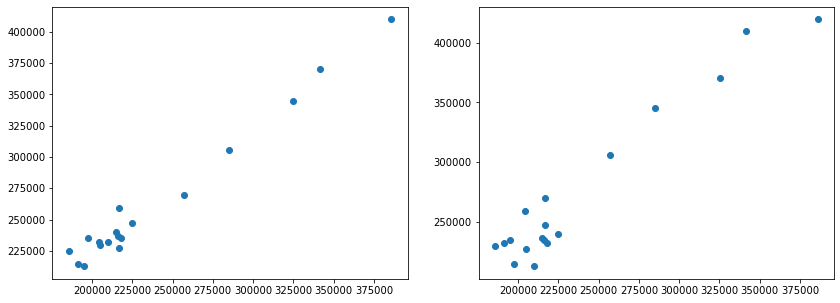

In [11]:
# test spatial correlation
test = df_mp_tm_sp[df_mp_tm_sp['NBHD_ID'] == 6]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (14,5))
ax1.scatter(test['Median_Neighbor_Last_Year_Price'], test['Last_Year_Price'])
ax2.scatter(test['Median_Neighbor_Last_Year_Price'], test['SALE_PRICE'])
plt.show()

### Linear Regression

In [12]:
##### from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

dfa = df_mp_tm_sp.copy()

dfy = dfa[['SALE_PRICE']]
dfx = dfa[['Last_Year_Price', 'Median_Neighbor_Last_Year_Price']]

x_train, x_test, y_train, y_test = train_test_split(dfx, dfy, 
                                                    test_size = 0.3, random_state = 42, shuffle = True)
lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print('Train Root Mean Squared Error: %d' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train Median absolute error: %.2f" % median_absolute_error(y_train, y_train_pred))
print('Train R squared: %.2f' % r2_score(y_train, y_train_pred))

print('Test Root Mean Squared Error: %d' % np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Test Median absolute error: %.2f" % median_absolute_error(y_test, y_test_pred))
print('Test R squared: %.2f' % r2_score(y_test, y_test_pred))

Train Root Mean Squared Error: 87745
Train Median absolute error: 24553.48
Train R squared: 0.83
Test Root Mean Squared Error: 57025
Test Median absolute error: 24188.39
Test R squared: 0.90


In [13]:
import pickle
from sklearn.externals import joblib

joblib.dump(lr, '../Models/neighborhood_price_prediction_lr.pkl') 

c:\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['../Models/neighborhood_price_prediction_lr.pkl']

### Prediction of Single-family House Median Price in 2020

In [14]:
x_pred = dfa[dfa['SALE_YEAR'] == 2019]
x_pred.drop(columns = ['Last_Year_Price', 'Median_Neighbor_Last_Year_Price', 'Last_Year_Price_diff', 'Median_Last_Year_Price_diff'], inplace = True)
x_pred['SALE_YEAR'] = 2020
x_pred.rename(columns = {'SALE_PRICE': 'Last_Year_Price', 'Median_Neighbor_Price': 'Median_Neighbor_Last_Year_Price'}, inplace = True)
y_pred = lr.predict(x_pred[['Last_Year_Price', 'Median_Neighbor_Last_Year_Price']])
x_pred['SALE_PRICE'] = y_pred

predicted_neighbor_price = pd.concat([x_pred, dfa[['SALE_YEAR','NBHD_ID','Last_Year_Price','Median_Neighbor_Last_Year_Price','SALE_PRICE']]])
predicted_neighbor_price.to_csv('../Data/predicted_neighbor_price.csv')

c:\python37\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python37\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v